# The Explainer Notebook

<h1 align="center">20 Years of Change: Voting Trends in Copenhagen’s National Elections</h1>

<div align="center">

Jasmin Thari (s204155), Johanne Franck (s204088) & Smilla Due ()

</div>


### Structure of this Notebook

This notebook consists of eight parts: [Motivation](#1), [Basic Statistics](#2), [Data Analysis](#3), [Genre](#4), [Visualizations](#5), [Discussion](#6), [Contributions](#7), and [References](#8).

In the first part, **Motivation**, we describe the project's goals and provide an overview of the dataset used.

In the second part, **Basic Statistics**, we give an overview of the dataset and its collection process. This section also includes a detailed explanation of the data cleaning procedures. Additionally, we present key dataset statistics and plots from our exploratory data analysis.

In the third part, **Data Analysis**, we describe our analytical approach and the insights derived from the data.

In the fourth part, **Genre**, we explain the genre chosen for our data story and outline the specific elements included in our data story.

In the fifth part, **Visualizations**, we present the visualizations created to support our data story. We explain the purpose of each visualization and how it contributes to the overall narrative.

In the sixth part, **Discussion**, we discuss the implications of our findings and how they relate to the broader context of voting trends in Copenhagen’s national elections. We also discuss the limitations of our analysis.

Finally, in the **Contributions** section, we detail the roles and responsibilities of each group member in the project.


### Table of Contents
1. [Motivation](#1)  
2. [Basic Statistics](#2)  
3. [Data Analysis](#3)  
4. [Genre](#4)  
5. [Visualizations](#5)  
6. [Discussion](#6)  
7. [Contributions](#7)  
8. [References](#8)

---


<a id="1"></a>
## 1.  Motivation

<!-- What is your dataset?
Why did you choose this/these particular dataset(s)?
What was your goal for the end user's experience? -->

### 1.1 Motivation and goal


### 1.2 Data

The data used in this study was obtained from **[Den Danske Valgdatabase](https://valgdatabase.dst.dk/)**, powered by *Danmarks Statistik*. This comprehensive database contains election data from Denmark spanning back to 1979. It includes data from various types of elections including:

- National parliamentary elections (*folketingsvalg*)  
- European Parliament elections (*europaparlamentsvalg*)  
- Referendums (*folkeafstemninger*)  
- Municipal and regional elections (*kommunalvalg* and *regionsrådsvalg*)  
- Parliamentary elections in Greenland and the Faroe Islands  

For the purpose of this project, we have chosen to focus specifically on **national elections in the Copenhagen constituency** over the past two decades. This includes the elections held in the years:  
**2001, 2005, 2007, 2011, 2015, and 2019** — resulting in a total of six elections.

The extracted election data includes:

- Total number of votes cast  
- Number of votes per political party across constituencies  

We filtered the dataset to include only constituencies within the **Copenhagen constituency (Københavns Storkreds)**. These constituencies are:

1. Østerbrokredsen  
2. Sundbyvesterkredsen  
3. Indre Bykredsen  
4. Sundbyøsterkredsen  
5. Nørrebrokredsen  
6. Bispebjergkredsen  
7. Brønshøjkredsen  
8. Valbykredsen  
9. Vesterbrokredsen  
10. Falkonerkredsen  
11. Slotskredsen  
12. Tårnbykredsen  

In addition to election data, **demographic and socioeconomic data** about the population of Copenhagen is also extracted. This supplementary data helps us better understand voting patterns in the context of population characteristics. The additional data categories include:

- **Demographic**: Gender, age, and ethnicity  
- **Socioeconomic**: Income, education level, and employment status  
- **Housing**: Type of housing, housing size, and housing prices  

In total, this resulted in **six `.csv` files**, which will be imported, cleaned, and explained in detail in the following sections.


**Libaries**

The libraries used for this project are presented and imported below.

In [1]:
import os
import json
from functools import partial

import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_hex
import matplotlib.patches as mpatches

import plotly.express as px
import plotly.io as pio

from bokeh.io import output_notebook, show
from bokeh.layouts import column, row                  
from bokeh.models import (ColumnDataSource, CheckboxGroup, CustomJS)
from bokeh.plotting import figure
from bokeh.palettes import Category10, Category20
from bokeh.transform import dodge

from shapely.geometry import shape
import folium
from folium import FeatureGroup
from folium.plugins import TimestampedGeoJson

import ipywidgets as widgets
from IPython.display import display, clear_output

# Pandas settings
pd.set_option('future.no_silent_downcasting', True)

In [2]:
hex_colors = ['#FDFAE1', '#241B5F', '#FFB400', '#4A4DE9', '#FF5A00', '#FF6273', '#FF95A1', '#F3DCC6'] 

expanded_colors = ['#241B5F', '#6A66B2','#FFB400', '#FFE299','#4A4DE9', '#A7AAFF', '#FF5A00', '#FF9D5C', '#FF6273', '#FFAAB2', '#FF95A1', '#FFD4DA', '#F3DCC6', '#EBD2BB']

wing_colors = {'left': '#d52729', 'right': '#00739b'}

def lighten_hex(hexcode: str, factor: float) -> str:
    """
    Return `hexcode` lightened toward white.

    * `factor = 0.0` → original colour
    * `factor = 1.0` → white
    """
    hexcode = hexcode.lstrip('#')
    r, g, b = (int(hexcode[i:i+2], 16) for i in (0, 2, 4))
    r = int(r + (255 - r) * factor)
    g = int(g + (255 - g) * factor)
    b = int(b + (255 - b) * factor)
    return f"#{r:02X}{g:02X}{b:02X}"

def make_palette(n_groups: int) -> list[str]:
    palette   = []
    base_len  = len(hex_colors)

    i = 0
    while len(palette) < n_groups:
        base_idx   = i // 2 % base_len          # 0‑7, 0‑7, 0‑7, …
        cycle      = i // (2 * base_len)        # 0 for first 16 colours,
                                                # 1 for next 16, …
        is_light   = i % 2 == 1                 # odd positions → lighter
        base_col   = hex_colors[base_idx]

        factor = 0.45 if is_light else 0.0
        factor += 0.25 * cycle                 # make later rings lighter
        factor = min(factor, 0.9)              # never reach pure white

        palette.append(lighten_hex(base_col, factor))
        i += 1

    return palette[:n_groups]

<a id="2"></a>
## 2.  Basic Statistics

This section is dividide into two parts: **2.1 Data Cleaning** and **2.2 Explorative Analysis**. In the first part, we load the data, clean it, and provide explanations of the cleaning process. In the second part, we present some basic statistics and visualizations of the data.

### 2.1 Data Cleaning

In this section, we load and clean the data. Overall, we work with three different datasets:

1. **Geographical data**: Contains geographic information at the constituency level. We use this dataset to filter the other datasets so that only constituencies within the Copenhagen area are included. 

2. **Election data**: Contains the number of votes received by each political party in each constituency, for each election year.

3. **Population data**: Contains information about the population at the constituency level. This data is used to analyze voting patterns in relation to various population characteristics. To make the analysis more manageable, we divide this dataset into the following subsets:
   - **Demographic data**: Includes information such as *gender*, *age*, and *citizenship*.
   - **Origin**: Includes data on *immigrants and descendants*. 
   - **Socioeconomic data**: Covers *employment status* and *branch of work*.
   - **Education data**: Covers *educational level*.
   - **Income support**: Includes data on *income support*.
   - **Income data**: Contains information on *income*.
   - **Ownership**: Covers types of *ownership of housing*. 
   - **Housing type**: Specifies the *type of housing* people live in.
   - **Housing size**: Contains data on *the size of house*.

Both the election data and population data are initially in **wide format**, meaning each row represents a constituency and each column represents a variable. We convert the datasets into **long format** using the `melt` function. In long format, each row represents a single observation (e.g., a specific value for a variable in a constituency and year), making it easier to filter, group, and analyze the data.

##### 2.1.1 Geography data
The first dataset we will import is the **geography data**. This dataset contains information about the geographical areas in Copenhagen, including the names of the constituencies and their corresponding codes. This dataset is essential for linking the election data and population data to the geographical areas in Copenhagen.

The first step is to filter the dataset to only include the constituencies in the Copenhagen constituency. Next, we create a mapping between the constituency names and their corresponding codes. This mapping will be used throughout the notebook. 

In [3]:
# Load the data
df_geo = pd.read_csv('Data/processed/Geografi.csv', sep=';', decimal=',', na_values='-')
df_geo.columns = df_geo.columns.str.replace(' ', '', regex=True)

# Filter the data to only keep Copenhagen Constituencies 
df_geo_cph = df_geo.query("Storkredsnavn=='Københavns Storkreds'").drop_duplicates()
df_geo_cph['KredsNr'] = df_geo_cph['KredsNr'].astype(int)

# Keep only the necessary columns
df_geo_cph = df_geo_cph[['KredsNr', 'Kredsnavn','KommuneNr','Kommunenavn']]

# Replace Utterslev with Bispebjerg
df_geo_cph['Kredsnavn'] = df_geo_cph['Kredsnavn'].replace({'6. Utterslev':'6. Bispebjerg'})

# Drop duplicates
df_geo_cph = df_geo_cph.drop_duplicates(subset=['KredsNr', 'Kredsnavn','KommuneNr','Kommunenavn'])

print("Geography data shape:", df_geo_cph.shape)

Geography data shape: (13, 4)


In [4]:
# Split the 'Kredsnavn' column into two parts: ID and Name
constituency_split = df_geo_cph['Kredsnavn'].drop_duplicates().str.split('.', n=1, expand=True)
constituency_split.columns = ['ConstituencyID', 'ConstituencyName']

# Convert ID column to integers and strip whitespace from the names
constituency_split['ConstituencyID'] = constituency_split['ConstituencyID'].astype(int)
constituency_split['ConstituencyName'] = constituency_split['ConstituencyName'].str.strip()

# Create a mapping from ID to Name
constituency_id_to_name = dict(zip(constituency_split['ConstituencyID'], constituency_split['ConstituencyName']))

# Create a reverse mapping from Name to ID
constituency_name_to_id = {name: id_ for id_, name in constituency_id_to_name.items()}

In [90]:
constituency_split

,ConstituencyID,ConstituencyName
0,1,Østerbro
5,2,Sundbyvester
9,3,Indre By
13,4,Sundbyøster
17,5,Nørrebro
23,6,Bispebjerg
27,7,Brønshøj
36,8,Valby
42,9,Vesterbro
53,10,Falkoner


##### 2.1.2 Election data
The second dataset we will import is the **election data**. This dataset is structured in wide format, where each row correspond to a constituency and each column corresponds to a political party per year, resulting in 172 columns. As this is a very inconvenient format, we will reshape the dataset to long format. 

First, we will filter the data to only include the constituencies in the Copenhagen constituency using the defined map. Next, we will reshape the dataset to long format, where each row corresponds to a constituency-year-party combination.

In [5]:
# Load the election data
df_election = pd.read_csv('Data/processed/Valgdata.csv', sep=';' , decimal=',', na_values='-')
df_election.columns = df_election.columns.str.replace(' ', '', regex=True)

# Filter the election data to only keep the relevant constituencies
df_elec_cph = df_election[df_election['KredsNr'].isin([str(k) for k in constituency_id_to_name.keys()])]
df_elec_cph.loc[:, 'KredsNr'] = df_elec_cph['KredsNr'].astype(int)

print("Election data shape:", df_elec_cph.shape)

Election data shape: (12, 172)


In [6]:
# Select vote cols (start with "FV")
vote_columns = [col for col in df_elec_cph.columns if col.startswith("FV")]

# Melt the dataframe to long format
df_elec_cph_long = df_elec_cph.melt(
    id_vars=['KredsNr'],
    value_vars=vote_columns,
    var_name='YearParty',
    value_name='Votes')

# Split the 'YearParty' column into 'Year' and 'Party'
df_elec_cph_long[['Year', 'Partyname']] = df_elec_cph_long['YearParty'].str.extract(r'FV(\d{4})-(.+)')

# Drop columns and reorder
df_elec_cph_long = df_elec_cph_long.drop(columns='YearParty')
df_elec_cph_long = df_elec_cph_long[['KredsNr', 'Year', 'Partyname', 'Votes']]

# Replace NaN values in Votes with 0
df_elec_cph_long['Votes'] = df_elec_cph_long['Votes'].fillna(0)

# Convert 'Year' and KredsNr to integer
df_elec_cph_long['Year'] = df_elec_cph_long['Year'].astype(int)
df_elec_cph_long['KredsNr'] = df_elec_cph_long['KredsNr'].astype(int)

print("Election data long format shape:", df_elec_cph_long.shape)

Election data long format shape: (2016, 4)


In the column `party_name`, we have the all parties represented in the elections - besides that we also have the total number of votes cast, blank votes, the number of invalid votes and eligible voters. However, for the main part of the analysis, we are interested in the political parties, and we also want to divide the votes into *left* and *right* wing. Therefore, we will create a new column `Wing` that indicates whether the party is left or right.

In [7]:
# All parties in the dataset
parties = ['A.Socialdemokratiet','B.DetRadikaleVenstre', 'C.DetKonservativeFolkeparti','D.Centrum-Demokraterne', 'F.SF-SocialistiskFolkeparti',
           'I.LiberalAlliance', 'K.Kristendemokraterne', 'O.DanskFolkeparti','M.Minoritetspartiet', 'V.Venstre,DanmarksLiberaleParti',
           'Y.NyAlliance', 'Ø.Enhedslisten-DeRød-Grønne','Q.FrieGrønne,DanmarksNyeVenstrefløjsparti','Å.Alternativet',   'P.StramKurs', 
           'Æ.Danmarksdemokraterne-IngerStøjberg', 'E.KlausRiskærPedersen']

wing = {
    "left": ['A.Socialdemokratiet',
             'F.SF-SocialistiskFolkeparti',
             'Ø.Enhedslisten-DeRød-Grønne',
             'Q.FrieGrønne,DanmarksNyeVenstrefløjsparti',
             'Å.Alternativet',
             'B.DetRadikaleVenstre',
             'D.Centrum-Demokraterne',
             'M.Minoritetspartiet'],
    "right": ['C.DetKonservativeFolkeparti',
              'V.Venstre,DanmarksLiberaleParti',
              'I.LiberalAlliance',
              'O.DanskFolkeparti',
              'Æ.Danmarksdemokraterne-IngerStøjberg',
              'P.StramKurs',
              'K.Kristendemokraterne',
              'Y.NyAlliance',
              'E.KlausRiskærPedersen']}

In [8]:
df_elec_cph_long['Wing'] = df_elec_cph_long['Partyname'].apply(
    lambda x: 'left' if x in wing['left'] else ('right' if x in wing['right'] else ''))

##### 2.1.3 Population Data
The third dataset we will import is the **population data**. This dataset contains information about the population in Denmark. The first step is to filter the dataset to only include the constituencies in the Copenhagen constituency using the defined map. 

As the data is structured in wide format with 11374 columns, we will split the data into sub dataframe and into long format, each corresponding to a specific characteristic. 

In [9]:
# Load the population data
df_population = pd.read_csv("Data/processed/Befolkning.csv", sep=';', low_memory=False, decimal=',', na_values='-')
df_population.columns = df_population.columns.str.replace(' ', '', regex=True)

# Filter the population data to only keep the relevant constituencies
df_population_cph = df_population[df_population['KredsNr'].isin([str(k) for k in constituency_id_to_name.keys()])]
df_population_cph.loc[:, 'KredsNr'] = df_population_cph['KredsNr'].astype(int)

print(f"Population data shape: {df_population_cph.shape}")

Population data shape: (12, 11374)


The dataset contains several columns that consist entirely of `NaN` values. These columns will therefore be dropped.

In addition, some rows contain missing values. Upon inspection, these `NaN` entries appear to correspond to cases where the count is effectively zero—indicating that no individuals in that particular category were present in the given constituency. 

For example, a column like  
`FV2015-Antalpersoneropgjortefterstatsborgerskabkønogaldersgrupper_Kvinder10-14år_09.Nordamerika`  
represents the number of girls aged 10–14 with North American citizenship in a specific constituency. If the value is missing (`NaN`), it likely means that no such individuals were registered in the data. In such cases, we will treat `NaN` as `0`.



In [10]:
# Drop columns with all NaN values
df_population_cph = df_population_cph.dropna(axis=1, how='all')
print(f"Population data shape after dropping empty columns: {df_population_cph.shape}")

Population data shape after dropping empty columns: (12, 5824)


In [11]:
# Replace NaN values with 0 & convert to numeric
df_population_cph.fillna(0, inplace=True) 
df_population_cph = df_population_cph.apply(pd.to_numeric, errors='coerce')

**Deomographics**

In [12]:
# Extract the demographic columns
demographics_cols = [
    col for col in df_population_cph.columns
    if col.startswith("FV") and "Antalpersoneropgjortefter" in col]

# Melt the DataFrame
df_demo_long = df_population_cph.melt(
    id_vars=['Gruppe', 'KredsNr'],
    value_vars=demographics_cols,
    var_name='RawColumn',
    value_name='Count')

# Extract the fields using regex: FV<year>-Antalpersoner..._<Gender><Age>_<CitizenshipCode>.<CitizenshipName>
df_demo_long[['Year', 'GenderAge', 'Citizenship']] = df_demo_long['RawColumn'].str.extract(
    r'FV(\d{4})-Antalpersoner.*?_(\w+\d+-?\d*år)_(?:\d+\.)?(.+)$')

# Separate Gender and Age
df_demo_long[['Gender', 'Age']] = df_demo_long['GenderAge'].str.extract(r'(\D+)(\d+-?\d*år)')

# Reorder and clean
df_demo_long = df_demo_long.drop(columns=['RawColumn', 'GenderAge'])
df_demo_long = df_demo_long[['Gruppe', 'KredsNr', 'Year', 'Gender', 'Age', 'Citizenship', 'Count']]

print(f"Population demographics data shape: {df_demo_long.shape}")

Population demographics data shape: (27648, 7)


Since there are repeated or inconsistent values in the Citizenship column, we define a mapping to standardize and convert them into a more readable and consistent format. The mapping is as follows:

In [13]:
citizenship_map_en = {
    'Danmark': 'Denmark',
    'Nordiskelande': 'Nordic countries',
    'Tyrkiet': 'Turkey',
    'TidligereJugoslavien': 'Former Yugoslavia',
    'GamleEU-lande': 'Old EU countries',
    'ØvrigegamleEU-lande': 'Old EU countries', 
    'NyeEU-lande': 'New EU countries',
    'ØvrigeEuropa': 'Other European countries',
    'Afrika': 'Africa',
    'Nordamerika': 'North America',
    'Syd-ogMellemamerika': 'South and Central America',
    'Syd-ogMellemam.': 'South and Central America',
    'AsienogOceanien': 'Asia and Oceania',
    'Asienogoceanien': 'Asia and Oceania',
    'Uoplyst': 'Unspecified/Stateless',
    'Uoplyst/statsløse': 'Unspecified/Stateless',
}

df_demo_long['Citizenship'] = df_demo_long['Citizenship'].replace(citizenship_map_en)

**Origin**

In [14]:
# Filter relevant columns
origin_cols = [
    col for col in df_population_cph.columns
    if "Indvandrereogefterkommerefordeltefteroprindelsesland" in col]

# Melt to long format
df_origin_long = df_population_cph.melt(
    id_vars=['Gruppe', 'KredsNr'],
    value_vars=origin_cols,
    var_name='RawColumn',
    value_name='Count')

# Extract year, gender, age, origin
df_origin_long[['Year', 'GenderAge', 'Origin']] = df_origin_long['RawColumn'].str.extract(
    r'FV(\d{4})-Indvandrereogefterkommerefordeltefteroprindelsesland_(\D+\d+-?\d*år)_(?:\d+\.)?(.+)$')

# Split gender and age
df_origin_long[['Gender', 'Age']] = df_origin_long['GenderAge'].str.extract(r'(\D+)(\d+-?\d*år)')

# Clean up
df_origin_long = df_origin_long.drop(columns=['RawColumn', 'GenderAge'])
df_origin_long['Age'] = df_origin_long['Age'].str.replace('år', '', regex=False)

# Apply the citizenship mapping
df_origin_long['Origin'] = df_origin_long['Origin'].replace(citizenship_map_en)

print(f"Population origin data shape: {df_origin_long.shape}")

Population origin data shape: (25296, 7)


**Socio-economic**

In [15]:
# Extract the socioeconomic columns
socioeconomic_cols = [
    col for col in df_population_cph.columns
    if col.startswith("FV") and "Socio-økonomiskstatusogbrancherfordeltpåafstemningsområder" in col]

# Melt to long format
df_socio_long = df_population_cph.melt(
    id_vars=['Gruppe', 'KredsNr'],
    value_vars=socioeconomic_cols,
    var_name='RawColumn',
    value_name='Count')

# Extract Year, Employment Group, and Industry
df_socio_long[['Year', 'EmploymentGroup', 'Industry']] = df_socio_long['RawColumn'].str.extract(
    r'FV(\d{4})-Socio-økonomiskstatusogbrancherfordeltpåafstemningsområder_\d+\.(.+?)_(.+)')

# Clean up columns
df_socio_long = df_socio_long.drop(columns=['RawColumn'])
df_socio_long = df_socio_long[['Gruppe', 'KredsNr', 'Year', 'EmploymentGroup', 'Industry', 'Count']]

print(f"Socioeconomic data shape: {df_socio_long.shape}")

Socioeconomic data shape: (5760, 6)


As we have inconsistent values in the column `Industry`, we will create a mapping to standardize the values. Also, we will translate the values into English. The mappings are as follows:

In [ ]:
industry_mapping = {
    '01.Landbrugskovbrugogfiskeri': 'Agriculture, Forestry and Fishing',
    '02.Industriråstofindvindingogforsyningsvirksomhed': 'Manufacturing, Mining and Utilities',
    '03.Byggeoganlæg': 'Construction',
    '04.Handelogtransportmv.': 'Trade and Transport',
    '05.Informationogkommunikation': 'Information and Communication',
    '06.Finansieringogforsikring': 'Finance and Insurance',
    '07.Ejendomshandelogudlejning': 'Real Estate',
    '08.Erhvervsservice': 'Business Services',
    '09.Offentligadministrationundervisningogsundhed': 'Public Administration, Education and Health',
    '10.Kulturfritidogandenservice': 'Culture, Leisure and Other Services',
    '11.Ikkebeskæftiget': 'Not Employed',
    '12.Uoplystaktivitet': 'Unknown Activity',
    
    # Also map to englisgh names
    'Landbrugskovbrugogfiskeri': 'Agriculture, Forestry and Fishing',
    'Industriråstofindvindingogforsyningsvirksomhed': 'Manufacturing, Mining and Utilities',
    'Byggeoganlæg': 'Construction',
    'Handelogtransportmv.': 'Trade and Transport',
    'Informationogkommunikation': 'Information and Communication',
    'Finansieringogforsikring': 'Finance and Insurance',
    'Ejendomshandelogudlejning': 'Real Estate',
    'Erhvervsservice': 'Business Services',
    'Offentligadministrationundervisningogsundhed': 'Public Administration, Education and Health',
    'Kulturfritidogandenservice': 'Culture, Leisure and Other Services',
    'Ikkebeskæftiget': 'Not Employed',
    'Uoplystaktivitet': 'Unknown Activity'
}

# should be good mapping now
status_mapping = { 
    'Selvstændigogmedhj.': 'Self-employed and Assistants',
    'Topledere': 'Executives',
    'Lønmodtagerepåhøjtniveau': 'Employees at High Skill Level',
    'Lønmodtagerepåmellemniveau': 'Employees at Medium Skill Level',
    'Lønmodtagerepågrundniveau': 'Employees at Basic Skill Level',
    'Øvrigelønmodtagere': 'Employees at Basic Skill Level',
    'Arbejdsløse': 'Unemployed',
    'Øvrige(offentligtforsørgede)': 'Publicly Supported',
    'Uddannelsessøgende': 'Education Seekers',
    'Folke-ogtjenestemandspension': 'Pensioners',
    'Efterløn': 'Pensioners',
    'Børn': 'Children'
}

df_socio_long['Industry'] = df_socio_long['Industry'].map(industry_mapping)
df_socio_long['EmploymentGroup'] = df_socio_long['EmploymentGroup'].map(status_mapping)

Source for mapping the socio status: https://samfundsfag.dk/begreber/sociologi/social-differentiering-kulturelle-moenstre/sociooekonomisk-klassifikation/?fbclid=IwZXh0bgNhZW0CMTEAAR5Hq-9PMJjMZQGEe_z1qB_EzswXhnksNY3ZPrIaAsWmncSzFe0yM3WSZbAN-w_aem_HqaLamHZsURXMZmeIWAczg

**Education**

In [58]:
# Extract the education columns
educ_columns = [
    col for col in df_population_cph.columns
    if col.startswith("FV") and "Højstfuldførteerhvervsuddannelseogaldersgrupper" in col]

# Melt the DataFrame
df_educ_long = df_population_cph.melt(
    id_vars=['Gruppe', 'KredsNr'],
    value_vars=educ_columns,
    var_name='RawColumn',
    value_name='Count')

# Extract the fields using regex: FV<year>-Højstfuldførteer..._<Age>_<EducationLevel>
df_educ_long[['Year', 'Age', 'EducationLevel']] = df_educ_long['RawColumn'].str.extract(
    r'FV(\d{4})-Højstfuldførteerhvervsuddannelseogaldersgrupper_(\d{1,3}-?\d*år)(?:_(?:\d+\.)?(.+))?$')

# Remove 'år' from age
df_educ_long['Age'] = df_educ_long['Age'].str.replace('år', '', regex=False)

# Reorder and clean
df_educ_long = df_educ_long.drop(columns=['RawColumn'])
df_educ_long = df_educ_long[['Gruppe', 'KredsNr', 'Year', 'Age', 'EducationLevel', 'Count']]

# Drop NaN values
df_educ_long = df_educ_long.dropna(subset=['Year', 'Age', 'EducationLevel'])

print(f"Education data shape: {df_educ_long.shape}")

Education data shape: (6624, 6)


In [59]:
education_mapping = {
    'Grundskole': 'Primary School',
    'Almengymnasial': 'General Upper Secondary',
    'Erhvervsgymnaisal': 'Vocational Upper Secondary',
    'Erhvervsfaglig': 'Vocational Education',
    'Kortvideregående': 'Short-cycle Higher Education',
    'Mellemlangvideregående': 'Medium-cycle Higher Education',
    'Langvideregående': 'Long-cycle Higher Education',
    'Uoplyst': 'Unspecified'
}
df_educ_long['EducationLevel'] = df_educ_long['EducationLevel'].map(education_mapping)

**Type of income support**

In [60]:
# Extract the support columns
support_cols = [
    col for col in df_population_cph.columns
    if col.startswith("FV") and "Personerefterforsørgelsestype" in col]

# Melt the DataFrame
df_support_long = df_population_cph.melt(
    id_vars=['Gruppe', 'KredsNr'],
    value_vars=support_cols,
    var_name='RawColumn',
    value_name='Count')

# Extract Year and SupportType
df_support_long[['Year', 'SupportType']] = df_support_long['RawColumn'].str.extract(
    r'FV(\d{4})-Personerefterforsørgelsestype_\d+\.(.+)')

# Clean up
df_support_long = df_support_long.drop(columns='RawColumn')
df_support_long = df_support_long[['Gruppe', 'KredsNr', 'Year', 'SupportType', 'Count']]

print(f"Support data shape: {df_support_long.shape}")

Support data shape: (576, 5)


Edited here in mapping:

In [61]:
support_mapping = {
    'Arbejdsløshedsdagpenge': 'Unemployment Benefits',
    'LedighedsydelseogFleksjob': 'Unemployment Benefits',
    'Aktivering': 'Unemployment Benefits',
    'Sygedagpenge': 'Health / Disability Support',
    'Kontanthjælp': 'Social Assistance (Cash Benefits)',
    'Revalidering': 'Health / Disability Support',
    'Barselsdagpenge': 'Parental Leave Benefits',
    'Førtidspension': 'Health / Disability Support',
    'Efterløn': 'Pension Support',
    'Folkepension': 'Pension Support',
    'Modtagerikkeydelser': 'No Received Benefits',
    'Antalpersonerialt': 'Total Number of Persons'
}
df_support_long['SupportType'] = df_support_long['SupportType'].map(support_mapping)

In [62]:
# 6 unique types + denominator
df_support_long['SupportType'].unique()

array(['Unemployment Benefits', 'Health / Disability Support',
       'Social Assistance (Cash Benefits)', 'Parental Leave Benefits',
       'Pension Support', 'No Received Benefits',
       'Total Number of Persons'], dtype=object)

Inspiration from the categories that DST seperate their kontantydelser : Source

https://www.dst.dk/da/Statistik/emner/oekonomi/offentlig-oekonomi/sociale-udgifter

Also from: "Offentligt forsøgede" what the category cover: source: https://www.dst.dk/da/Statistik/emner/sociale-forhold/offentligt-forsoergede Both SU (students), cash benefits, (normally parental leave, but this is noted in another category), (efterløn, førtidspension, also noted in another category)

**Income**

In [63]:
# Filter relevant income columns
income_cols = [
    col for col in df_population_cph.columns
    if col.startswith("FV") and "Husstandsindkomsterfordeltpåafstemningsområder" in col]

# Melt
df_income_long = df_population_cph.melt(
    id_vars=['Gruppe', 'KredsNr'],
    value_vars=income_cols,
    var_name='RawColumn',
    value_name='Value')

# Extract Year + IncomeMetric
df_income_long[['Year', 'IncomeMetric']] = df_income_long['RawColumn'].str.extract(
    r'FV(\d{4})-Husstandsindkomsterfordeltpåafstemningsområder_(.+)')

# Clean up
df_income_long = df_income_long.drop(columns='RawColumn')
df_income_long = df_income_long[['Gruppe', 'KredsNr', 'Year', 'IncomeMetric', 'Value']]

print(f"Income data shape: {df_income_long.shape}")

Income data shape: (816, 5)


**Ownership type**

In [64]:
# Identify relevant boligtype columns
ownership_cols = [
    col for col in df_population_cph.columns
    if col.startswith("FV") and "Ejerforhold" in col]

# Melt the DataFrame
df_ownership_type_long = df_population_cph.melt(
    id_vars=['Gruppe', 'KredsNr'],
    value_vars=ownership_cols,
    var_name='RawColumn',
    value_name='Count')

# Extract: year, aggregate level (boliger/personer), housing type
df_ownership_type_long[['Year', 'AggregateLevel', 'OwnershipType']] = df_ownership_type_long['RawColumn'].str.extract(
    r'FV(\d{4})-Ejerforhold_Antal_(boliger|personer)_\d+\.(.+)')

df_ownership_type_long['AggregateLevel'] = df_ownership_type_long['AggregateLevel'].map({'boliger': 'Units', 'personer': 'Residents'})

# Reorder columns
df_ownership_type_long = df_ownership_type_long[['Gruppe', 'KredsNr', 'Year', 'AggregateLevel', 'OwnershipType', 'Count']]

# Drop columns with NaN values
df_ownership_type_long = df_ownership_type_long.dropna(subset=['Year', 'AggregateLevel', 'OwnershipType'])

print(f"Ownership data shape: {df_ownership_type_long.shape}")


Ownership data shape: (432, 6)


In [65]:
housing_mapping = {
    'Ejerbolig': 'Owner-occupied',
    'Andelsbolig': 'Cooperative Housing',
    'Almennyttigbolig': 'Public Housing',
    'Lejerioffentligtejet': 'Rented – Publicly Owned',
    'Privatlejerbolig': 'Rented – Privately Owned',
    'Øvrigebeboedeboliger': 'Other Inhabited Dwellings'
}
df_ownership_type_long['OwnershipType'] = df_ownership_type_long['OwnershipType'].map(housing_mapping)

**House type**

In [66]:
# Identify relevant boligtype columns
housing_type_cols = [
    col for col in df_population_cph.columns
    if col.startswith("FV") and "Boligtype" in col]

# Melt the DataFrame
df_housing_type_long = df_population_cph.melt(
    id_vars=['Gruppe', 'KredsNr'],
    value_vars=housing_type_cols,
    var_name='RawColumn',
    value_name='Count')

# Extract: year, aggregate level (boliger/personer), housing type
df_housing_type_long[['Year', 'AggregateLevel', 'HouseType']] = df_housing_type_long['RawColumn'].str.extract(
    r'FV(\d{4})-Boligtype_Antal_(boliger|personer)_\d+\.(.+)')

df_housing_type_long['AggregateLevel'] = df_housing_type_long['AggregateLevel'].map({'boliger': 'Units', 'personer': 'Residents'})

# Reorder columns 
df_housing_type_long = df_housing_type_long[['Gruppe', 'KredsNr', 'Year', 'AggregateLevel', 'HouseType', 'Count']]

# Drop columns with NaN values
df_housing_type_long = df_housing_type_long.dropna(subset=['Year', 'AggregateLevel', 'HouseType'])

print(f"Housing data shape: {df_housing_type_long.shape}")


Housing data shape: (432, 6)


In [67]:
house_type_mapping = {
    'Stuehuseogparcelhuse': 'Detached Houses',
    'Række-ogkædehuse': 'Terraced and Linked Houses',
    'Flerfamiliehuse': 'Multi-family Houses',
    'Kollegier': 'Student Housing',
    'Sommerhuse': 'Holiday Homes',
    'Øvrigeboliger': 'Other Dwellings'
}
df_housing_type_long['HouseType'] = df_housing_type_long['HouseType'].map(house_type_mapping)

**Housing size**

In [68]:
hoursing_size_columns = [
    col for col in df_population_cph.columns
    if col.startswith("FV") and "boligstørrelse" in col]

# Melt to long format
df_house_size_long = df_population_cph.melt(
    id_vars=['Gruppe', 'KredsNr'],
    value_vars=hoursing_size_columns,
    var_name='RawColumn',
    value_name='Count')

# Extract year, aggregate level, and size category
df_house_size_long[['Year', 'AggregateLevel', 'HouseSize']] = df_house_size_long['RawColumn'].str.extract(
    r'FV(\d{4})-Boligerogpersonerefterboligstørrelse_\d+\.(?:Antal)?(boliger|personer)_(.+)')

df_house_size_long['AggregateLevel'] = df_house_size_long['AggregateLevel'].map({'boliger': 'Units', 'personer': 'Residents'})

# Reorder columns
df_house_size_long = df_house_size_long[['Gruppe', 'KredsNr', 'Year', 'AggregateLevel', 'HouseSize', 'Count']]

# Drop columns with NaN values
df_house_size_long = df_house_size_long.dropna(subset=['Year', 'AggregateLevel', 'HouseSize'])

print(f"House size data shape: {df_house_size_long.shape}")

House size data shape: (936, 6)


##### Support Analysis Demographics data

In [69]:
def plot_grouped_bar_dist(years, counts, legend, values, html, color_map=None, show_percentage=False, title=""):
    # Create the DataFrame
    df = pd.DataFrame({'Year': years, f'{legend}': counts, 'Value': values})
    # Convert to strings to ensure categorical x-axis
    df['Year'] = df['Year'].astype(str)
    df[f'{legend}'] = df[f'{legend}'].astype(str)

    # Compute percentage if needed
    if show_percentage:
        df['Percentage'] = df.groupby('Year')['Value'].transform(lambda x: x / x.sum() * 100)
        y_col = 'Percentage'
        text_format = '%{text:.1f}%'
        y_title = 'Percentage (%)'
    else:
        y_col = 'Value'
        text_format = '%{text:.0f}'
        y_title = 'Count'

    
    # Determine if color_map is a list or a dict
    if isinstance(color_map, list):
        fig = px.bar(
            df,
            x='Year',
            y=y_col,
            color=f'{legend}',
            text=y_col,
            barmode='group',
            color_discrete_sequence=color_map  
        )
    else:
        fig = px.bar(
            df,
            x='Year',
            y=y_col,
            color=f'{legend}',
            text=y_col,
            barmode='group',
            color_discrete_map=color_map  
        )
        
    fig.update_traces(
        texttemplate=text_format,
        textposition='outside',
        marker_line_color='lightgrey',
        marker_line_width=1.5
    )

    fig.update_layout(
        title=title,
        title_x=0.5,
        uniformtext_minsize=8,
        uniformtext_mode='hide',
        hovermode="x unified",
        plot_bgcolor='rgba(0,0,0,0)',
        yaxis_title=y_title,
        xaxis_title="Year"
    )

    fig.update_xaxes(showline=True, linewidth=1, linecolor='lightgrey',
                     showgrid=True, gridwidth=1, gridcolor='lightgrey')
    fig.update_yaxes(showline=True, linewidth=1, linecolor='lightgrey',
                     showgrid=True, gridwidth=1, gridcolor='lightgrey')

    fig.write_html(html)
    fig.show()


In [81]:
## Support
# Group and aggregate
df_total_pers = df_support_long.query("SupportType=='Total Number of Persons'").groupby('Year')['Count'].sum().reset_index()
df_total_pers = df_total_pers.rename(columns={'Count': 'TotalPersons'})

df_support_count = df_support_long.query("SupportType!='Total Number of Persons'").groupby(['Year', 'SupportType'])['Count'].sum().reset_index()

df_support_ratio = pd.merge(df_support_count, df_total_pers, on='Year')
df_support_ratio['SupportRatio'] = df_support_ratio['Count'] / df_support_ratio['TotalPersons']



# Exclude "No Received Benefits"
df_support_filtered = df_support_ratio[df_support_ratio['SupportType'] != 'No Received Benefits']
df_no_benefits = df_support_ratio[df_support_ratio['SupportType'] == 'No Received Benefits']
print("'No Benefits' ratio by year:")
print(df_no_benefits[['Year', 'SupportRatio']])


'No Benefits' ratio by year:
    Year  SupportRatio
1   2011      0.641793
7   2015      0.660979
13  2019      0.687349
19  2022      0.687349


In [94]:
import plotly.graph_objects as go

# Colors for support types
support_types = df_support_ratio['SupportType'].unique()
color_map = dict(zip(support_types, expanded_colors[:len(support_types)]))

# Initialize figure
fig = go.Figure()

fig.update_xaxes(showgrid=True, gridcolor='lightgrey', gridwidth=0.5)
fig.update_yaxes(showgrid=True, gridcolor='lightgrey', gridwidth=0.5)

for support_type in support_types:
    df_subset = df_support_ratio[df_support_ratio['SupportType'] == support_type]
    
    fig.add_trace(go.Bar(
        x=df_subset['Year'],
        y=df_subset['SupportRatio'],
        name=support_type,
        marker_color=color_map[support_type],
        visible=True if support_type != 'No Received Benefits' else 'legendonly'  # Hide initially
    ))

# Layout tweaks
fig.update_layout(
    barmode='group',
    title='Support Type Distribution by Year (Toggle No Benefits)',
    yaxis_title='Percentage of Population',
    xaxis_title='Year',
    legend_title='Support Type',
    yaxis_tickformat='.0%',
    plot_bgcolor='rgba(0,0,0,0)'
)

fig.show()


Overall across all of CPH the Pension support decreases slightly from 2011 to 2022.

Support ratio = SupportTypeCount/Total Persons in District

also plot pr neightborhood.

In [111]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Merge district names
df_support_named = df_support_long.merge(
    constituency_split,
    left_on='KredsNr',
    right_on='ConstituencyID'
)

# Compute total persons per district & year
df_total = (
    df_support_named[df_support_named['SupportType'] == 'Total Number of Persons']
    .groupby(['Year', 'KredsNr', 'ConstituencyName'])['Count']
    .sum()
    .reset_index()
    .rename(columns={'Count': 'TotalPersons'})
)

# Compute support counts
df_support = (
    df_support_named[df_support_named['SupportType'] != 'Total Number of Persons']
    .groupby(['Year', 'KredsNr', 'ConstituencyName', 'SupportType'])['Count']
    .sum()
    .reset_index()
)

# Merge and calculate ratios (for titles only)
df_ratio = df_support.merge(
    df_total, on=['Year', 'KredsNr', 'ConstituencyName']
)
df_ratio['SupportRatio'] = df_ratio['Count'] / df_ratio['TotalPersons']

# Calculate 'No Received Benefits' percentage for titles
df_no_benefits = df_ratio[df_ratio['SupportType'] == 'No Received Benefits']
no_benefits_avg = df_no_benefits.groupby('ConstituencyName')['SupportRatio'].mean().round(3)

# Filter out 'No Received Benefits' from plot data
df_plot = df_support[df_support['SupportType'] != 'No Received Benefits']

# Support type colors
support_types = df_plot['SupportType'].unique()
color_map = dict(zip(support_types, expanded_colors[:len(support_types)]))

# Setup subplots
titles = [
    f"{district} ({no_benefits_avg[district]*100:.1f}% No Benefits)"
    for district in sorted(df_plot['ConstituencyName'].unique())
]

fig = make_subplots(
    rows=3, cols=4,
    subplot_titles=titles
    # Remove shared_yaxes=True for independent scaling
)

# Plot each district
for idx, district in enumerate(sorted(df_plot['ConstituencyName'].unique())):
    row = idx // 4 + 1
    col = idx % 4 + 1
    df_district = df_plot[df_plot['ConstituencyName'] == district]
    
    for support_type in support_types:
        df_subset = df_district[df_district['SupportType'] == support_type].sort_values('Year')
        
        fig.add_trace(
            go.Bar(
                x=df_subset['Year'],
                y=df_subset['Count'],  # Use counts, not ratios
                name=support_type,
                marker_color=color_map[support_type],
                showlegend=(idx == 0)  # Show legend only once
            ),
            row=row, col=col
        )

# Layout tweaks
fig.update_layout(
    barmode='group',  
    height=900,
    width=1400,
    title_text='Support Type Distribution by Year Across Districts (Counts, Grouped)',
    yaxis_title='Number of Persons',
    xaxis_title='Year',
    plot_bgcolor='rgba(0,0,0,0)',
)

# Grid styling
fig.update_xaxes(showgrid=True, gridcolor='lightgrey', gridwidth=0.5)
fig.update_yaxes(showgrid=True, gridcolor='lightgrey', gridwidth=0.5)

fig.show()


###### THis is not the analysis we want to do, to forced analytics

In [72]:
# Sum left and right wing votes per district per year
df_votes_summary = df_elec_cph_long.groupby(['Year', 'KredsNr', 'Wing'])['Votes'].sum().reset_index()

# Total votes per district per year
df_total_votes = df_elec_cph_long.groupby(['Year', 'KredsNr'])['Votes'].sum().reset_index().rename(columns={'Votes': 'TotalVotes'})

# Merge and calculate vote shares
df_votes_summary = df_votes_summary.merge(df_total_votes, on=['Year', 'KredsNr'])
df_votes_summary['VoteShare'] = df_votes_summary['Votes'] / df_votes_summary['TotalVotes']


In [73]:
# Aggregate support per district per year (excluding total persons)
df_support_district = df_support_long[df_support_long['SupportType'] != 'Total Number of Persons']
df_support_district = df_support_district.groupby(['Year', 'KredsNr', 'SupportType'])['Count'].sum().reset_index()

# Merge with total persons per district per year
df_total_district = df_support_long[df_support_long['SupportType'] == 'Total Number of Persons'].groupby(['Year', 'KredsNr'])['Count'].sum().reset_index().rename(columns={'Count': 'TotalPersons'})

df_support_district = df_support_district.merge(df_total_district, on=['Year', 'KredsNr'])
df_support_district['SupportRatio'] = df_support_district['Count'] / df_support_district['TotalPersons']


In [74]:
# Merge support data with vote shares
# Ensure 'Year' is integer in both dataframes
df_support_district['Year'] = df_support_district['Year'].astype(int)
df_votes_summary['Year'] = df_votes_summary['Year'].astype(int)

# Now merge
df_support_elections = df_support_district.merge(df_votes_summary, on=['Year', 'KredsNr'])



In [75]:
# Example for Unemployment Benefits vs. Left-Wing Vote Share
df_plot = df_support_elections[df_support_elections['SupportType'] == 'Unemployment Benefits']
df_plot = df_plot[df_plot['Wing'] == 'left']


In [93]:
# Ensure Year is string for discrete legend
df_plot['Year'] = df_plot['Year'].astype(str)

# Keep only KredsNr as label (remove year!)
df_plot['Label'] = df_plot['KredsNr'].astype(str)

# Plot
fig = px.scatter(df_plot, 
                 x='SupportRatio', 
                 y='VoteShare', 
                 color='Year', 
                 text='Label',  # Only district numbers
                 color_discrete_sequence=hex_colors,  # Your palette!
                 title='Unemployment Support vs. Left-Wing Vote Share (Districts Labeled)')

fig.update_traces(textposition='top center', textfont_size=9,
                  marker=dict(size=10, line=dict(width=1, color='black')),
                  hovertemplate="<b>Year:</b> %{customdata[0]}<br><b>District:</b> %{text}<br><b>Support Ratio:</b> %{x:.2f}<br><b>Vote Share:</b> %{y:.2f}")

fig.update_layout(
    legend_title_text='Election Year',
    plot_bgcolor='rgba(0,0,0,0)'
)

fig.show()


In [77]:
from scipy.stats import pearsonr

# Example: correlation across all years
corr, p_value = pearsonr(df_plot['SupportRatio'], df_plot['VoteShare'])
print(f"Correlation: {corr:.2f}, p-value: {p_value:.4f}")


Correlation: 0.60, p-value: 0.0000


##### Socio demographics analysis

In [78]:
expanded_colors = ['#241B5F', '#6A66B2','#FFB400', '#FFE299','#4A4DE9', 
                   '#A7AAFF', '#FF5A00', '#FF9D5C', '#FF6273', 
                   '#FFAAB2', '#FF95A1', '#FFD4DA', '#F3DCC6', '#EBD2BB']


In [79]:
output_notebook()

# Lists of categories
employment_groups = sorted(df_socio_long['EmploymentGroup'].unique())
industries        = sorted(df_socio_long['Industry'].unique())
years             = sorted(df_socio_long['Year'].unique())

# Helper to aggregate counts for the selected industries
def make_pivot(selected_industries):
    return (
        df_socio_long[df_socio_long['Industry'].isin(selected_industries)]
        .groupby(['Year', 'EmploymentGroup'])['Count']
        .sum()
        .unstack(fill_value=0)
        .reindex(index=years, fill_value=0)
        .reset_index()
        .astype({'Year': str})
    )

source = ColumnDataSource(make_pivot(industries))

# Figure: grouped bars + Employment‑group legend on the right
palette = make_palette(len(employment_groups))


p = figure(
    x_range=[str(y) for y in years],
    height=400, width=900,
    title="Employment‑group counts by Year (filterable by Industry)",
    tools="pan,box_zoom,reset,save"
)

bar_w   = 0.8 / len(employment_groups)
offsets = [-0.4 + bar_w/2 + i*bar_w for i in range(len(employment_groups))]

for off, grp, col in zip(offsets, employment_groups, palette):
    p.vbar(
        x=dodge('Year', off, p.x_range),
        top=grp,
        width=bar_w,
        source=source,
        color=col,
        legend_label=grp,
        alpha=0.85
    )

p.y_range.start   = 0
p.xaxis.axis_label = "Year"
p.yaxis.axis_label = "Count"
p.legend.click_policy = "hide"   

# Move Employment‑group legend outside, on the right
leg = p.legend[0]
p.add_layout(leg, 'right')
leg.orientation = "vertical"
leg.title       = "Employment group"

# Widget: industries ON/OFF
checkbox = CheckboxGroup(
    labels=industries,
    active=list(range(len(industries))),
    width=200,                            # keeps a tidy narrow column
)

checkbox.js_on_change(
    'active',
    CustomJS(
        args=dict(
            source     = source,
            checkbox   = checkbox,
            groups     = employment_groups,
            all_years  = [str(y) for y in years],
            original   = df_socio_long.to_dict('records')
        ),
        code="""
            const selected = checkbox.active.map(i => checkbox.labels[i]);

            const data = {Year: all_years.slice()};
            for (const g of groups) { data[g] = Array(all_years.length).fill(0); }

            for (const row of original) {
                if (!selected.includes(row.Industry)) { continue; }
                const yr  = row.Year.toString();
                const idx = all_years.indexOf(yr);
                data[row.EmploymentGroup][idx] += row.Count;
            }

            source.data = data;
            source.change.emit();
        """
    )
)

show(row(checkbox, p, sizing_mode="scale_width"))

Loading BokehJS ...

ValueError: legend_label value must be a string

In [ ]:
# Aggregate counts by Year and EmploymentGroup
df_socio_year = (
    df_socio_long.groupby(['Year', 'EmploymentGroup'])['Count']
    .sum()
    .reset_index()
)

# Calculate percentage per year (normalize to 100%)
df_socio_year_total = df_socio_year.groupby('Year')['Count'].sum().reset_index().rename(columns={'Count': 'TotalCount'})
df_socio_year = df_socio_year.merge(df_socio_year_total, on='Year')
df_socio_year['Percentage'] = df_socio_year['Count'] / df_socio_year['TotalCount'] * 100


In [ ]:
# Define the color mapping for Employment Groups
employment_groups = df_socio_year['EmploymentGroup'].unique()
color_map = dict(zip(sorted(employment_groups), expanded_colors[:len(employment_groups)]))

# Plot
fig = px.area(
    df_socio_year,
    x='Year',
    y='Percentage',
    color='EmploymentGroup',
    title='Socioeconomic Group Distribution Over Time (Normalized to 100%)',
    color_discrete_map=color_map
)

# Only one hover box for the hovered group
fig.update_traces(
    hovertemplate='<b>%{fullData.name}</b><br>Year: %{x}<br>Percentage: %{y:.2f}%',
    hoverinfo="skip"  # Prevents extra info outside the box
)

fig.update_layout(
    hoverlabel=dict(
        namelength=-1,
        bgcolor="white",
        bordercolor="black",
        font_size=12
    ),
    legend_tracegroupgap=0,
    legend_itemclick=False,
    legend_itemdoubleclick=False
)

fig.show()


change order.

Something seems wrong. Some categories in 2015 have 0% : Pensioners and children and students, which is obviously wrong

In [ ]:
df_socio_long[df_socio_long['EmploymentGroup']=='Children'].groupby('Year').count()

,Gruppe,KredsNr,EmploymentGroup,Industry,Count
Year,,,,,
2011,144,144,144,144,144
2019,12,12,12,12,12
2022,12,12,12,12,12


##### 2.2 Explorative Analysis

In [ ]:
def plot_bar_dist(values, counts, html, color, show_percentage=False, title=""):
    values = [str(v) for v in values]
    plot_df = pd.DataFrame({'Value': values, 'Count': counts})
    plot_df['Value'] = pd.Categorical(plot_df['Value'], categories=values, ordered=True)
    
    # Compute percentage if required
    if show_percentage:
        plot_df['Percentage'] = plot_df['Count'] * 100
        y_col = 'Percentage'
        text_format = '%{text:.1f}%'
        y_title = 'Percentage (%)'
    else:
        y_col = 'Count'
        text_format = '%{text:.0f}'
        y_title = 'Count'
    
    fig = px.bar(plot_df, x='Value', y=y_col, text=y_col)
    
    fig.update_traces(
        texttemplate=text_format,
        textposition='outside',
        marker_color=color,
        marker_line_color='black',
        marker_line_width=1.5
    )
    
    fig.update_layout(
        title=title,
        title_x=0.5,  # center the title
        uniformtext_minsize=8,
        uniformtext_mode='hide',
        hovermode="x unified",
        plot_bgcolor='rgba(0,0,0,0)',
        yaxis_title=y_title,
        xaxis_title=""
    )
    
    fig.update_xaxes(showline=True, linewidth=1, linecolor='lightgrey', 
                     showgrid=True, gridwidth=1, gridcolor='lightgrey')
    fig.update_yaxes(showline=True, linewidth=1, linecolor='lightgrey',
                     showgrid=True, gridwidth=1, gridcolor='lightgrey')
    
    fig.write_html(html)
    fig.show()


In [ ]:
# Total number of people who actually voted, per year
df_voter_turnout = df_elec_cph_long.query("Partyname == 'Afgivnestemmer'").groupby(['Year']).agg(TotalVotesCast=('Votes', 'sum')).reset_index()

# Total number of people who were eligible to vote, per year
df_voter_eligibility = df_elec_cph_long.query("Partyname == 'Stemmeberettigede'").groupby(['Year']).agg(TotalEligibleVoters=('Votes', 'sum')).reset_index()

# Voter turnout ratio = votes cast / eligible voters
df_turnout_ratio = pd.DataFrame(df_voter_turnout['Year'].copy())
df_turnout_ratio['Ratio'] = df_voter_turnout['TotalVotesCast'] / df_voter_eligibility['TotalEligibleVoters']

In [ ]:
plot_bar_dist(df_turnout_ratio['Year'].values, df_turnout_ratio['Ratio'].values, 'test.html', color=hex_colors[2], show_percentage=True, title="Voter Turnout Ratio in Copenhagen Constituencies (2011-2021)")

In [ ]:
## Percentage of voter turnout summary
# Calculate percentage and round to 2 decimals
df_turnout_summary = df_turnout_ratio.copy()
df_turnout_summary['Turnout (%)'] = (df_turnout_summary['Ratio'] * 100).round(2)

# Display the summary table
print(df_turnout_summary[['Year', 'Turnout (%)']])


   Year  Turnout (%)
0  2005        81.56
1  2007        84.78
2  2011        86.42
3  2015        84.61
4  2019        84.84
5  2022        84.01


In [ ]:
df_elec_cph_long['Wing'] = df_elec_cph_long['Partyname'].apply(
    lambda x: 'left' if x in wing['left'] else ('right' if x in wing['right'] else 'other')
)

In [ ]:
# Get total voters per year
df_total_voters = df_elec_cph_long.query("Wing in ['left', 'right']").groupby('Year')['Votes'].sum().reset_index()
df_total_voters = df_total_voters.rename(columns={'Votes': 'TotalVotes'})

# Get vote sum per wing per year
df_wing_sum = df_elec_cph_long.query("Wing in ['left', 'right']").groupby(['Year', 'Wing'])['Votes'].sum().reset_index()

# Merge and compute ratio
df_wing_ratio = pd.merge(df_wing_sum, df_total_voters, on='Year')
df_wing_ratio['WingRatio'] = df_wing_ratio['Votes'] / df_wing_ratio['TotalVotes']

In [ ]:
def plot_grouped_bar_dist(years, counts, legend, values, html, color_map=None, show_percentage=False, title=""):
    # Create the DataFrame
    df = pd.DataFrame({'Year': years, f'{legend}': counts, 'Value': values})
    # Convert to strings to ensure categorical x-axis
    df['Year'] = df['Year'].astype(str)
    df[f'{legend}'] = df[f'{legend}'].astype(str)

    # Compute percentage if needed
    if show_percentage:
        df['Percentage'] = df.groupby('Year')['Value'].transform(lambda x: x / x.sum() * 100)
        y_col = 'Percentage'
        text_format = '%{text:.1f}%'
        y_title = 'Percentage (%)'
    else:
        y_col = 'Value'
        text_format = '%{text:.0f}'
        y_title = 'Count'

    
    # Determine if color_map is a list or a dict
    if isinstance(color_map, list):
        fig = px.bar(
            df,
            x='Year',
            y=y_col,
            color=f'{legend}',
            text=y_col,
            barmode='group',
            color_discrete_sequence=color_map  
        )
    else:
        fig = px.bar(
            df,
            x='Year',
            y=y_col,
            color=f'{legend}',
            text=y_col,
            barmode='group',
            color_discrete_map=color_map  
        )
        
    fig.update_traces(
        texttemplate=text_format,
        textposition='outside',
        marker_line_color='lightgrey',
        marker_line_width=1.5
    )

    fig.update_layout(
        title=title,
        title_x=0.5,
        uniformtext_minsize=8,
        uniformtext_mode='hide',
        hovermode="x unified",
        plot_bgcolor='rgba(0,0,0,0)',
        yaxis_title=y_title,
        xaxis_title="Year"
    )

    fig.update_xaxes(showline=True, linewidth=1, linecolor='lightgrey',
                     showgrid=True, gridwidth=1, gridcolor='lightgrey')
    fig.update_yaxes(showline=True, linewidth=1, linecolor='lightgrey',
                     showgrid=True, gridwidth=1, gridcolor='lightgrey')

    fig.write_html(html)
    fig.show()


In [ ]:
plot_grouped_bar_dist(
    years=df_wing_ratio['Year'],
    counts=df_wing_ratio['Wing'],
    legend='Wing',
    values=df_wing_ratio['Votes'],  # or 'WingRatio' for percentage
    html="wing_votes.html",
    color_map=wing_colors,
    show_percentage=True,
    title="Vote Share by Wing per Year"
)

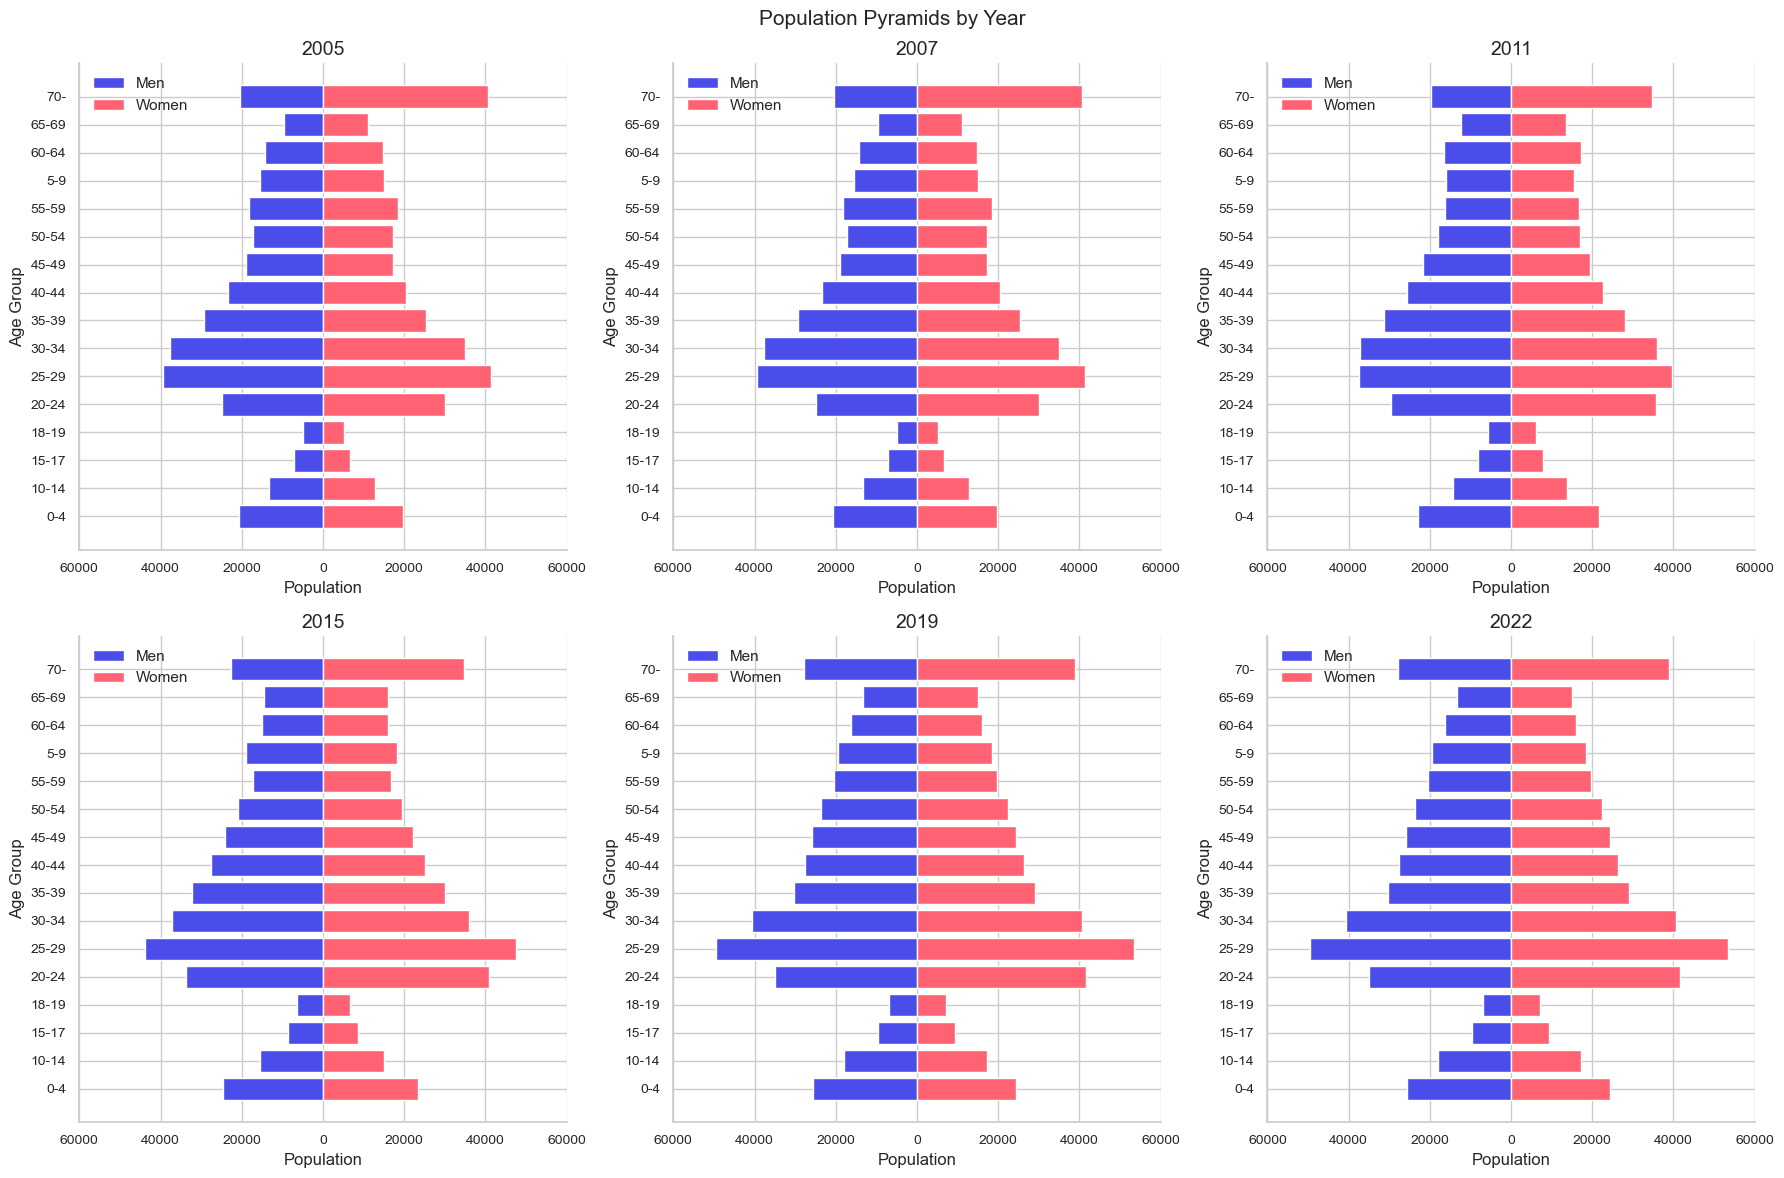

In [ ]:
# Set seaborn style
sns.set_theme(style="whitegrid")

# Age order
df_demo_long['Age'] = df_demo_long['Age'].str.replace('år', '').str.strip()
age_order = df_demo_long['Age'].unique()

# Filter data
df_demo_filtered = df_demo_long[
    df_demo_long['Gender'].isin(['Mænd', 'Kvinder']) &
    df_demo_long['Age'].isin(age_order)
]

# Color palette
color_m = '#F4A261'  # Warm orange
color_k = '#E9C46A'  # Soft yellow

color_m = hex_colors[3]  # Warm orange
color_k = hex_colors[5] # Soft yellow

# Setup subplots
years = sorted(df_demo_filtered['Year'].unique())
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axs = axs.flatten()

# Calculate global max population count for consistent x-axis
max_count = 0
for year in years[:6]:
    df_year = df_demo_filtered[df_demo_filtered['Year'] == year]
    pop_by_age_gender = df_year.groupby(['Age', 'Gender'])['Count'].sum().unstack().fillna(0)
    max_year = pop_by_age_gender.values.max()
    if max_year > max_count:
        max_count = max_year

#Plot each year's pyramid
for i, year in enumerate(years[:6]):
    ax = axs[i]
    df_year = df_demo_filtered[df_demo_filtered['Year'] == year]

    # Group data
    pop_by_age_gender = df_year.groupby(['Age', 'Gender'])['Count'].sum().unstack().fillna(0)
    pop_by_age_gender = pop_by_age_gender.loc[age_order]

    # Plot bars
    ax.barh(pop_by_age_gender.index, -pop_by_age_gender['Mænd'], color=color_m, label='Men')
    ax.barh(pop_by_age_gender.index, pop_by_age_gender['Kvinder'], color=color_k, label='Women')


    # Title and labels
    ax.set_title(f"{year}", fontsize=14)
    ax.set_ylabel('Age Group')
    ax.set_xlabel('Population')
    ax.set_xlim(-max_count, max_count)
    
    xticks = ax.get_xticks()
    ax.set_xticks(xticks)
    ax.set_xticklabels([f"{int(abs(label))}" for label in ax.get_xticks()])

    # Legend
    ax.legend(loc='upper left', bbox_to_anchor=(0, 1), frameon=False)

    # Clean style
    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

# Hide unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

# Title and layout
plt.suptitle("Population Pyramids by Year", fontsize=15)
plt.tight_layout()
plt.subplots_adjust()
plt.show()

In [ ]:
output_notebook()

# Lists of categories
employment_groups = sorted(df_socio_long['EmploymentGroup'].unique())
industries        = sorted(df_socio_long['Industry'].unique())
years             = sorted(df_socio_long['Year'].unique())

# Helper to aggregate counts for the selected industries
def make_pivot(selected_industries):
    return (
        df_socio_long[df_socio_long['Industry'].isin(selected_industries)]
        .groupby(['Year', 'EmploymentGroup'])['Count']
        .sum()
        .unstack(fill_value=0)
        .reindex(index=years, fill_value=0)
        .reset_index()
        .astype({'Year': str})
    )

source = ColumnDataSource(make_pivot(industries))

# Figure: grouped bars + Employment‑group legend on the right
palette = make_palette(len(employment_groups))


p = figure(
    x_range=[str(y) for y in years],
    height=400, width=900,
    title="Employment‑group counts by Year (filterable by Industry)",
    tools="pan,box_zoom,reset,save"
)

bar_w   = 0.8 / len(employment_groups)
offsets = [-0.4 + bar_w/2 + i*bar_w for i in range(len(employment_groups))]

for off, grp, col in zip(offsets, employment_groups, palette):
    p.vbar(
        x=dodge('Year', off, p.x_range),
        top=grp,
        width=bar_w,
        source=source,
        color=col,
        legend_label=grp,
        alpha=0.85
    )

p.y_range.start   = 0
p.xaxis.axis_label = "Year"
p.yaxis.axis_label = "Count"
p.legend.click_policy = "hide"   

# Move Employment‑group legend outside, on the right
leg = p.legend[0]
p.add_layout(leg, 'right')
leg.orientation = "vertical"
leg.title       = "Employment group"

# Widget: industries ON/OFF
checkbox = CheckboxGroup(
    labels=industries,
    active=list(range(len(industries))),
    width=200,                            # keeps a tidy narrow column
)

checkbox.js_on_change(
    'active',
    CustomJS(
        args=dict(
            source     = source,
            checkbox   = checkbox,
            groups     = employment_groups,
            all_years  = [str(y) for y in years],
            original   = df_socio_long.to_dict('records')
        ),
        code="""
            const selected = checkbox.active.map(i => checkbox.labels[i]);

            const data = {Year: all_years.slice()};
            for (const g of groups) { data[g] = Array(all_years.length).fill(0); }

            for (const row of original) {
                if (!selected.includes(row.Industry)) { continue; }
                const yr  = row.Year.toString();
                const idx = all_years.indexOf(yr);
                data[row.EmploymentGroup][idx] += row.Count;
            }

            source.data = data;
            source.change.emit();
        """
    )
)

show(row(checkbox, p, sizing_mode="scale_width"))

Loading BokehJS ...

In [ ]:
# Group and aggregate
df_total_pers = df_support_long.query("SupportType=='Total Number of Persons'").groupby('Year')['Count'].sum().reset_index()
df_total_pers = df_total_pers.rename(columns={'Count': 'TotalPersons'})

df_support_count = df_support_long.query("SupportType!='Total Number of Persons'").groupby(['Year', 'SupportType'])['Count'].sum().reset_index()

df_support_ratio = pd.merge(df_support_count, df_total_pers, on='Year')
df_support_ratio['SupportRatio'] = df_support_ratio['Count'] / df_support_ratio['TotalPersons']

# Call the plot function
plot_grouped_bar_dist(
    years=df_support_ratio['Year'],
    counts=df_support_ratio['SupportType'],
    legend='Support Type',
    color_map = expanded_colors,
    values=df_support_ratio['SupportRatio'],
    html='support_type_by_year.html',
    title='Share of Support Type Distribution by Year', 
    show_percentage=True
)

In [ ]:
df_ownership_type_long['OwnershipType'].unique()

array(['Owner-occupied', 'Cooperative Housing', 'Public Housing',
       'Rented – Publicly Owned', 'Rented – Privately Owned',
       'Other Inhabited Dwellings'], dtype=object)

In [ ]:
df_ownership_type_long

,Gruppe,KredsNr,Year,AggregateLevel,OwnershipType,Count
0,101002,1,2015,Units,Owner-occupied,6238.0
1,101009,2,2015,Units,Owner-occupied,6891.0
2,101011,3,2015,Units,Owner-occupied,4840.0
3,101019,4,2015,Units,Owner-occupied,6221.0
4,101032,7,2015,Units,Owner-occupied,11318.0
...,...,...,...,...,...,...
907,101058,5,2022,Residents,Other Inhabited Dwellings,14464.0
908,101059,6,2022,Residents,Other Inhabited Dwellings,10993.0
909,147004,10,2022,Residents,Other Inhabited Dwellings,11822.0
910,147006,11,2022,Residents,Other Inhabited Dwellings,14705.0


In [ ]:
df_house_size_long

,Gruppe,KredsNr,Year,AggregateLevel,HouseSize,Count
0,101002,1,2015,Units,0-39m2,1884.0
1,101009,2,2015,Units,0-39m2,2509.0
2,101011,3,2015,Units,0-39m2,1305.0
3,101019,4,2015,Units,0-39m2,1408.0
4,101032,7,2015,Units,0-39m2,1370.0
...,...,...,...,...,...,...
991,101058,5,2022,Residents,200+m2,461.0
992,101059,6,2022,Residents,200+m2,541.0
993,147004,10,2022,Residents,200+m2,2527.0
994,147006,11,2022,Residents,200+m2,1120.0


In [ ]:
df_house_size_long['HouseSize'].unique()

array(['0-39m2', '40-79m2', '80-119m2', '120-159m2', '160-199m2',
       '200+m2', 'Uoplystareal'], dtype=object)